In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import os
import cmocean
import warnings
from IPython.display import Image

warnings.simplefilter("ignore")
plt.style.use("ggplot")

# Continental shelf area through time

## 1. Explore PaleoDEM dataset

Data from [here](https://www.earthbyte.org/paleodem-resource-scotese-and-wright-2018/).

In [2]:
def get_time(ds):
    """ Get time in Ma from dataset file path
    """
    fpath = ds.encoding['source']
    time = -float(os.path.split(fpath)[-1].split('_')[-1][:-5])
    
    return ds.assign(time=time)

In [3]:
# Open all datsets
ds = xr.open_mfdataset(r'../paleodem_netcdf/*.nc',
                       concat_dim='time',
                       preprocess=get_time,
                      )

ds = ds.sortby('time')

ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361, time: 109)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * time     (time) float64 -540.0 -535.0 -530.0 -525.0 ... -10.0 -5.0 -0.0
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(1, 181, 361), meta=np.ndarray>
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        
    history:      grdsample /Users/nickywright/PhD/scotese/paleogeographyconv...
    description:  
    GMT_version:  5.4.1 (r18208) [64-bit]

In [ ]:
# Grid plots through time
for idx, time_slice in enumerate(np.array_split(ds['time'], 6)):
    ds2 = ds.sel(time=time_slice)
    
    ds2['z'].plot.pcolormesh(x='lon', 
                             y='lat', 
                             col='time', 
                             col_wrap=4, 
                             cmap=cmocean.cm.topo,
                             vmin=-4000,
                            # levels=[-8000, -200, 0, 8000],
                             transform=ccrs.PlateCarree(),
                             subplot_kws={'projection': ccrs.Robinson()},
                             cbar_kwargs={'orientation':'horizontal',
                                          'pad':0.05, 
                                          'aspect':30, 
                                          'shrink':0.6,
                                         },                                        
                             figsize=(15, 15),
                            )

    plt.savefig(f'../png/paleo_bathymetry_{idx}.png')
    plt.close()

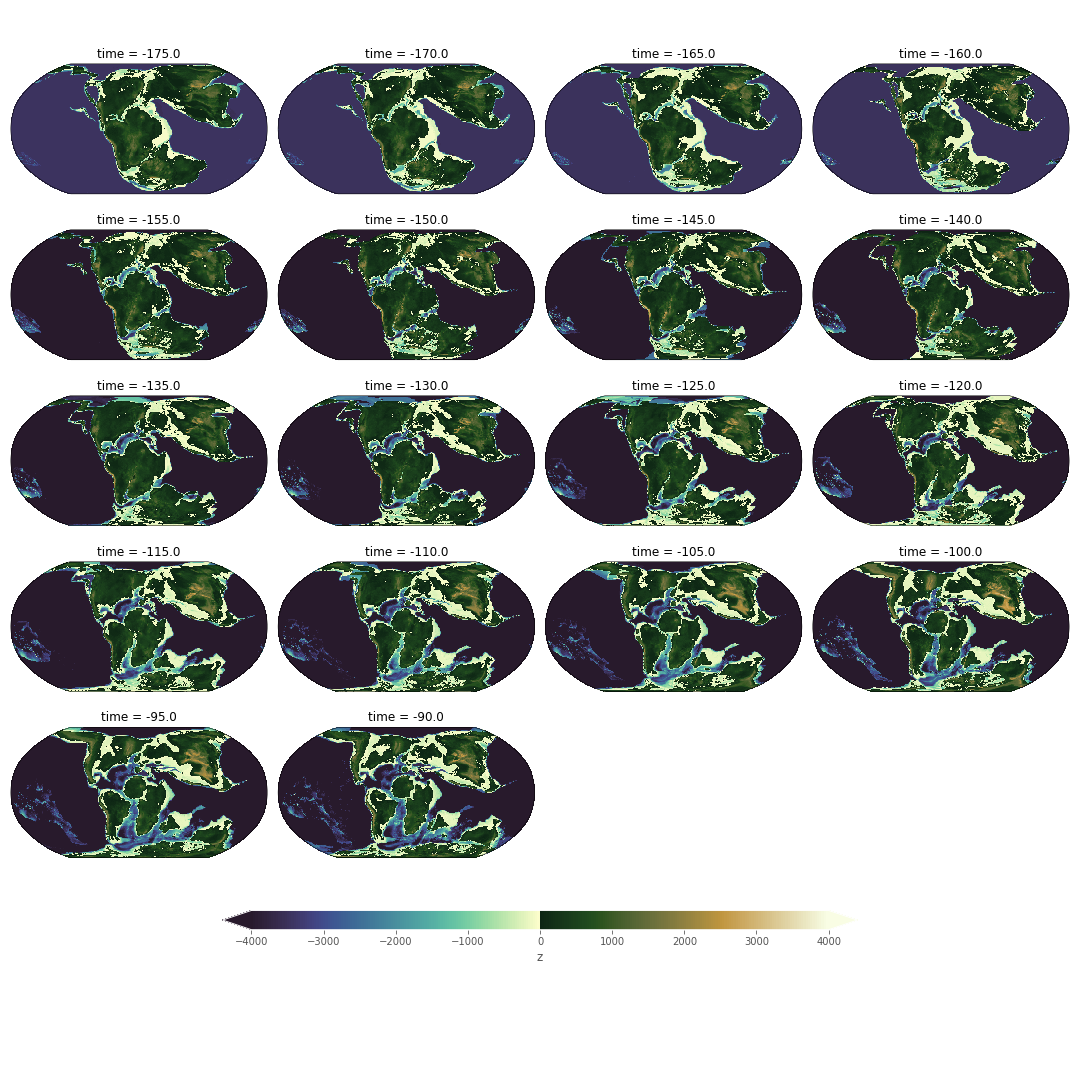

In [6]:
Image(f'../png/paleo_bathymetry_4.png')

## 2. Calculate areas

In [7]:
def wgs84_pixel_areas(pixel_size, center_lat):
    """ Calculates pixel areas for a WGS84 array (in m2).

    Adapted from: https://gis.stackexchange.com/a/288034/2131

    Args:
        pixel_size: Float. Length of side of pixel in degrees.
        center_lat: Array. Array of latitudes for pixel centres. 
                    Note: this value +/- half the `pixel-size` must 
                    not exceed 90/-90 degrees, or an invalid area 
                    will be calculated.

    Returns:
        Array. Areas of pixels of side length 'pixel_size' centered 
        at 'center_lat' in m2.

    """
    import numpy as np
    
    # WGS85 ellipsoid
    a = 6378137       # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    
    area_list = []
    
    for f in [center_lat+pixel_size/2, center_lat-pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        
        area_list.append(
            np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
        
    return pixel_size / 360. * (area_list[0] - area_list[1])

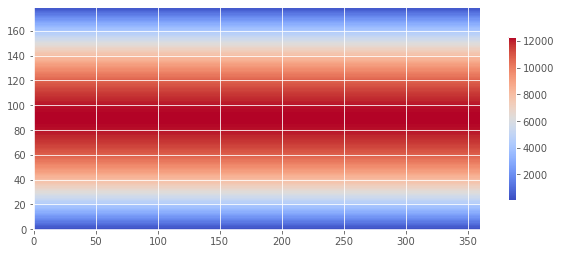

In [8]:
# Calcuate grid of pixel areas for 1 deg datasets
lats = np.arange(-89.5, 90, 1)
lons = np.arange(-179.5, 180, 1)
x, y = np.meshgrid(lons, lats)

area_km2 = wgs84_pixel_areas(1, y) / 1E6

fig = plt.figure(figsize=(10,10))
plt.imshow(area_km2, 
           origin='lower', 
           cmap='coolwarm',
          )
plt.colorbar(shrink=0.3)

In [9]:
shelf_min = -200
shelf_max = 0

area_list = []

for time_pt in ds['time']:
    data = ds['z'].sel(time=time_pt).values.copy()
    data = np.where((shelf_min < data) & (data <= shelf_max), data, np.nan)
    
    # Data appears to have one extra row and column. Strip off
    data = data[:-1, :-1]
    
    # Convert to bool grid
    is_shelf = np.isfinite(data)
    
    # Get areas for shelf cells only
    shelf_area = (area_km2 * is_shelf).sum()
    
    area_list.append(shelf_area)
    
# Build dataframe
df = pd.DataFrame({'time':ds['time'].values,
                   'shelf_area_km2':area_list})
df.set_index('time', inplace=True)
df['shelf_area_1E6km2'] = df['shelf_area_km2'] / 1E6
del df['shelf_area_km2']

df.head()    

,shelf_area_1E6km2
time,
-540.0,53.418904
-535.0,47.327785
-530.0,46.878249
-525.0,46.567424
-520.0,49.625401


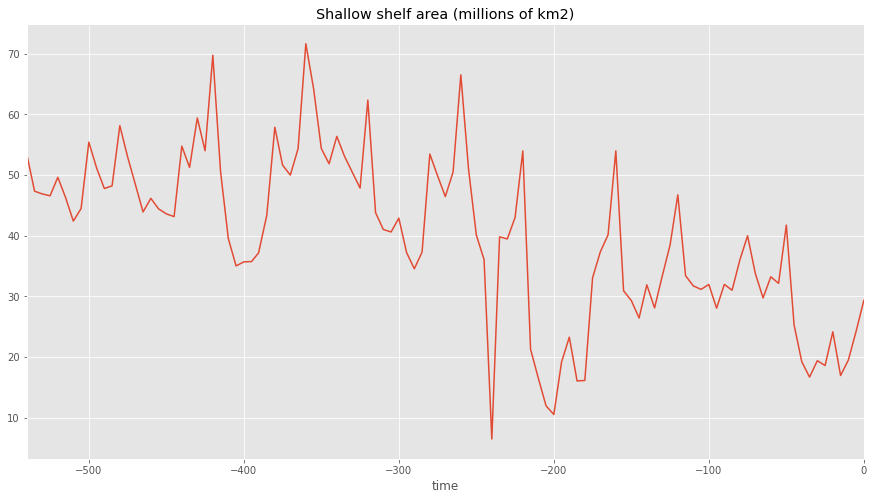

In [10]:
df.plot(title='Shallow shelf area (millions of km2)',
        figsize=(15,8),
        legend=False,
       )

plt.savefig('../png/shelf_area_through_time.png')